## DATA301 Project Google Cloud Part

## Loading Data

In [ ]:
import urllib.request
filename = 'sample_data/beeradvocate.json.gz'
urllib.request.urlretrieve('https://datarepo.eng.ucsd.edu/mcauley_group/data/beer/beeradvocate.json.gz', filename) # The URL to the BeerAdvocate dataset
print(f"File saved as {filename}")

File saved as sample_data/beeradvocate.json.gz


In [ ]:
!pip install ijson # Need to run this so we can run: import ijason

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 9.9 MB/s eta 0:00:00


In [ ]:
import gzip
import shutil
with gzip.open('sample_data/beeradvocate.json.gz', 'rb') as f_in:
    with open('beeradvocate_reviews.json', 'wb') as f_out:

        shutil.copyfileobj(f_in, f_out)
        print(f_in)

<gzip _io.BufferedReader name='sample_data/beeradvocate.json.gz' 0x7fef7293feb0>


In [ ]:
import json, ijson

def float_converter(string):
  """Converts the values from a string into a float that were extracted from the BeeerAdvocate JSON file"""
  try:
      converter = float(string)
  except ValueError:
    converter = string
  return converter



def jsonline_converter(file_entry, file_output, aspect_rates):
  """Grabbing the important variables and values that will be used in later algortihms and analysis"""

  with open(file_entry) as read_file, open(file_output, 'w') as output: # for opening a files, one for reading and one for writing
    output.write('[\n') # Initiates a new list of the things we need
    first = True # Determines whether to insert a new line in the output file

    for line in read_file: # Loops through the BeerAdvocate JSON file
      line = line.replace("'", '"') # Replaces single quotes with double quotes to make sure its a valid JSON syntax
      try:
          data = json.loads(line) # Parses a JSON formatted string and returns Python object
          selected_data = dict() # Creates new empty dictionary
          for i in aspect_rates: # Loops through all the variables that will be used in the project
              value = data.get(i) # Gets the values assoaciated with the syntax
              if value is not None:
                  selected_data[i] = float_converter(data.get(i)) # Converts it into a int value
          if not first:
              output.write(',\n') # If conditions not met then create a new dictionary lines
          first = False
          output.write(json.dumps(selected_data)) # Function then writes the rating dictionary to the output file using the json.dumps() method to convert it to a JSON string.
      except json.JSONDecodeError:
          pass # Ignore line sthat cannotbe parsed into a JSON
    output.write('\n]\n') # When loop completes, the function writes a closing square bracket ']' and a new line to the output file, indicating the end of the JSONL file.


aspect_rates = ['beer/name', 'beer/beerId', 'review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'review/overall', 'review/text']
jsonline_converter('beeradvocate_reviews.json', 'beeradvocate_reviews.jsonl', aspect_rates)

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Copying work from the Project

In [ ]:
%%writefile project_beeradvocate.py
import pyspark, time
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import sys
from operator import add


STOP_WORDS = {"you've", "that'll", 'isn', "shan't", 'haven', 'if', "weren't", 'couldn', 'needn', 'd', 'same', 'it', 'are', 'to', 'nor', 'being', "isn't", 'on', 'our', 'their', 'until', 'out', 'under', 'any', 'below', 'once', 'mustn', 'doesn', "hadn't", 'shan', 'y', 'yourself', 'at', 'each', 'few', 'can', 'here', 'don', 'shouldn', 'been', 'over', 'those', 'she', 'having', 'wasn', 'you', 'itself', 'down', 'your', 'above', 'have', "you're", 'too', 'wouldn', 'be', "doesn't", 'ourselves', 'her', 'aren', 'mightn', 'why', 'while', 'that', 'does', 'weren', 'won', 'were', 'there', 'a', 'm', 'yours', 'theirs', 'whom', 'when', 'about', 't', "couldn't", 'by', 'before', "shouldn't", 'hers', 'against', 're', 'now', 's', "wasn't", 'what', 'from', 'has', 'an', "didn't", 'himself', 'we', 'because', 'do', 'will', "wouldn't", 'doing', 'some', 'through', 'up', 've', 'was', 'into', "don't", "needn't", 'had', 'how', 'not', 'them', 'such', "mustn't", 'but', 'i', 'herself', 'as', 'than', 'its', 'who', 'very', 'all', 'this', 'in', 'then', 'ours', "won't", 'own', 'am', "aren't", 'him', 'which', 'didn', 'yourselves', "she's", "mightn't", 'me', 'off', 'where', 'ain', 'both', 'he', 'my', 'they', 'for', 'again', 'no', 'myself', "you'd", 'll', 'these', 'most', 'with', 'of', 'hasn', 'more', "should've", 'ma', 'just', 'should', 'so', 'hadn', 'o', 'his', "you'll", "hasn't", 'or', 'did', 'the', "it's", 'further', 'other', "haven't", 'themselves', 'between', 'during', 'and', 'only', 'is', 'after'}

if len(sys.argv) < 2:
  raise Exception("Input URI required")

sc = SparkContext()
spark = SparkSession(sc)

time_start = time.time()

user_reviews_df = spark.read.json(sys.argv[1], multiLine=True) # Reads a JSON Line file '.jsonl' into a dataframe using PySpark and the 'multiline' is to enable multiple lines of JSON objects
user_reviews_df_ids = user_reviews_df.rdd.zipWithUniqueId() # converts the dataframe into RDD along with its unique identifier

sampled_rdd = user_reviews_df_ids.sample(False, 0.02, seed = 42)

import re

def remove_nonletters(word):
  """Removes any nonletter words"""
  return re.sub(r'[^a-zA-Z]', '', word)

def split_remove_nonletters(line):
  result = []
  for word in line.split(" "):
    removed_token = remove_nonletters(word.lower())
    if removed_token != '':
      result.append((removed_token, 1))
  return result

def wc(review_str):
  result = {}
  for word in review_str.split():
    removed_token = remove_nonletters(word.lower())
    if removed_token != '' and removed_token not in STOP_WORDS:
      if removed_token not in result:
        result[removed_token] = 0
      result[removed_token] += 1
  return result

def overall_splitter(ratings):
  if ratings <= 6:
    return f'negative {ratings}'
  elif ratings > 6 and ratings <= 13:
    return f'neutral {ratings}'
  elif ratings > 13 and ratings <= 20:
    return f'positive {ratings}'
  else:
    return f'Exceeded the overall rating range of 20 by {ratings - 20}'


import math

def idf(user_count):
  n_reviews = user_reviews_df.count()
  combined_per_UCD = user_count.flatMap(lambda x: [(word, 1) for word in x[1].keys()]) # Initialise RDD containing a pair of tuple
  overall_UCD = combined_per_UCD.reduceByKey(lambda a, b: a + b) # Collecting all pairs with the same key
  idf_UCD = overall_UCD.map(lambda x: (x[0], math.log(n_reviews/x[1],2))) # math.log(Number of documents on the left side, # of times a word appears in those 4 documents)
  return idf_UCD

per_UDCR = sampled_rdd.map(lambda x: (x[1], (wc(x[0]['review/text']), x[0]['review/overall']))) # This alternative way of joining the User Text Reviews and Overall Ratings

word_idf = idf(per_UDCR)

def tf(UD_counts_ratings):
  counting_rating_word = UD_counts_ratings.flatMap(lambda kv: [((word, kv[1][1]), kv[1][0][word]) for word in kv[1][0].keys()])
  print(counting_rating_word.take(3))

  total_WRC = counting_rating_word.reduceByKey(lambda a, b: a + b)
  print(total_WRC.take(3))

  total_WCBR = total_WRC.map(lambda kv: (kv[0][1], kv[1]))
  print(total_WCBR.take(3))

  max_PUR = total_WCBR.reduceByKey(lambda a, b: max(a, b)).collectAsMap()
  print(max_PUR)

  UDCR_frequency = total_WRC.map(lambda kv: (kv[0], kv[1] / max_PUR[kv[0][1]]))
  return UDCR_frequency

per_UDR_tfs = tf(per_UDCR)
print(per_UDR_tfs.take(3))

def tfidfi(tfs, idfs):
  word_tfs = tfs.map(lambda kv: (kv[0][0], (kv[0][1], kv[1])))


  tfidf_join = word_tfs.join(idfs)
  print(tfidf_join.take(30)) # The output showing repeated term, it may indicate that this term have the highest significance within the BeerAdvocate document

  tfidf_result = tfidf_join.map(lambda kv: (kv[1][0][0], (kv[1][0][1] * kv[1][1], kv[0])))

  return tfidf_result


def cosine_similarity(u, v):
  """Computes cosine similarity between two lists of integers"""
  if u == v:
    return 1.0

  numerator = 0
  denominator_u = 0
  denominator_v = 0


  for i, j in zip(u, v):
    numerator += i * j
    denominator_u += i ** 2
    denominator_v += j ** 2

  cosine_similarity = numerator / (math.sqrt(denominator_u) * math.sqrt(denominator_v))

  return cosine_similarity

import statistics
import math

def mean_value_computation(rates):
  """Calculating the mean values for all of the rates user gave on apearance, aroma, palate, taste"""
  appearance_rates, aroma_rates, palate_rates, taste_rates = zip(*rates) ### unpacks the lists of tuples from each aspects of the beer

  mean_appearance_rate = statistics.mean(appearance_rates)
  mean_aroma_rate = statistics.mean(aroma_rates)
  mean_palate_rate = statistics.mean(palate_rates)
  mean_taste_rate = statistics.mean(taste_rates)


  return (math.ceil(mean_appearance_rate), math.ceil(mean_aroma_rate), math.ceil(mean_palate_rate), math.ceil(mean_taste_rate))

NOR_rdd = sampled_rdd.filter(lambda x : overall_splitter(x[0]["review/overall"]).split()[0] == 'negative') ### get the negative from the 'review/overall'
beer_aspect_rates = NOR_rdd.map(lambda x : (x[0]['review/overall'], (x[0]['review/appearance'], x[0]['review/aroma'], x[0]['review/palate'], x[0]['review/taste']))) ### Retrieving only the important variables

grouped = beer_aspect_rates.groupByKey() ### Grouping by the key (which is the 'review/overall')
mean_rates_rdd = grouped.mapValues(lambda x: mean_value_computation(x)) ### mapping through 'grouped' rdd then calulate all mean values

MRR_ascending = mean_rates_rdd.sortByKey()

print(MRR_ascending.collect())

def cos_sim(user_rates):
  Collection_AR = user_rates.collect()

  cosine_similarities = user_rates.map(lambda x : [((i, x[0]), cosine_similarity(x[1] , v)) for i, v in Collection_AR]).flatMap(lambda x : (i for i in x))

  return cosine_similarities


cos_sim_PUAR = cos_sim(MRR_ascending)
print(cos_sim_PUAR.take(5))

time_end = time.time()
print(f"elapsed time is {time_end-time_start}")

Overwriting project_beeradvocate.py


## Edit the cell to add your USERNAME

In [ ]:
USERNAME= 'moses' #You need to set this to a string of your "username", i.e. USERNAME="jatlas"
%env REGION=australia-southeast1
%env ZONE=australia-southeast1-a
%env PROJECT=data301-2023-$USERNAME
%env CLUSTER=data301-2023-$USERNAME-project-cluster
%env BUCKET=data301-2023-$USERNAME-project-bucket

env: REGION=australia-southeast1
env: ZONE=australia-southeast1-a
env: PROJECT=data301-2023-moses
env: CLUSTER=data301-2023-moses-project-cluster
env: BUCKET=data301-2023-moses-project-bucket


## Run code to setup google cloud project and storage bucket.

In [ ]:
!python3 -m pip install google-cloud-dataproc[libcst]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=0pRnf1TaNdgn0gQkbw1806lTi81jEc&prompt=consent&access_type=offline&code_challenge=_4abZA3Es2WTHeRMiKL7H9aHCEbFQuN9igSqkq1AuZ4&code_challenge_method=S256

Enter authorization code: 4/0AbUR2VOU1hcQGua6JYoJXZUxNgChHnIwHJ6JlrLAChaH32SBBy7PdZhvXktu_cx4b5rWsA

You are now logged in as [mosesvelano510@gmail.com].
Your current project is [data301-2023-moses].  You can change this setting by running:
  $ gcloud config set proje

In [ ]:
!gcloud config set project $PROJECT

Updated property [core/project].


In [ ]:
!gcloud services enable dataproc.googleapis.com cloudresourcemanager.googleapis.com

Operation "operations/acat.p2-316272433062-ac042733-494d-495b-a151-af60ac574904" finished successfully.


In [ ]:
!gsutil mb -c regional -l $REGION -p $PROJECT gs://$BUCKET

Creating gs://data301-2023-moses-project-bucket/...


In [ ]:
!gcloud storage cp ./beeradvocate_reviews.jsonl gs://$BUCKET

Copying file://./beeradvocate_reviews.jsonl to gs://data301-2023-moses-project-bucket/beeradvocate_reviews.jsonl

Average throughput: 19.4MiB/s


In [ ]:
### This is the original configuration we are again using 1 master/worker node with 1 vCPUs and 6GB of memory.
# !gcloud dataproc clusters create $CLUSTER --region=$REGION --bucket=$BUCKET --zone=$ZONE \
# --master-machine-type=custom-1-6144 \
# --image-version=1.5 --max-age=30m --single-node

## Modify this configuration the same way we did in lab3 for P=4, P=8, and P=16
!gcloud dataproc clusters create $CLUSTER --region=$REGION --bucket=$BUCKET --zone=$ZONE \
--master-machine-type=n1-standard-2 --worker-machine-type=n1-standard-8 \
--image-version=1.5 --max-age=30m --num-masters=1 --num-workers=2

Waiting on operation [projects/data301-2023-moses/regions/australia-southeast1/operations/ffb79ada-7615-3709-ad07-754c288eef6f].

Created [https://dataproc.googleapis.com/v1/projects/data301-2023-moses/regions/australia-southeast1/clusters/data301-2023-moses-project-cluster] Cluster placed in zone [australia-southeast1-a].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster=$CLUSTER --region=$REGION project_beeradvocate.py -- gs://$BUCKET/beeradvocate_reviews.jsonl

Job [f1bfa17184b64a69bde925d64629bc14] submitted.
Waiting for job output...
23/06/02 07:13:34 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/06/02 07:13:34 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/06/02 07:13:34 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/06/02 07:13:34 INFO org.spark_project.jetty.util.log: Logging initialized @5224ms to org.spark_project.jetty.util.log.Slf4jLog
23/06/02 07:13:34 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; jvm 1.8.0_362-b09
23/06/02 07:13:34 INFO org.spark_project.jetty.server.Server: Started @5392ms
23/06/02 07:13:34 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@24f5ea3d{HTTP/1.1, (http/1.1)}{0.0.0.0:39955}
23/06/02 07:13:36 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at data301-2023-moses-project-cluster-m/10.152.0.16:8032
23/06/02 07:13:37 INFO org.apache.hadoop.yarn.

In [ ]:
!gcloud dataproc clusters delete $CLUSTER --region=$REGION --quiet

Waiting on operation [projects/data301-2023-moses/regions/australia-southeast1/operations/70e03270-3061-3d73-baa3-c552c6ed05b7].
Deleted [https://dataproc.googleapis.com/v1/projects/data301-2023-moses/regions/australia-southeast1/clusters/data301-2023-moses-project-cluster].


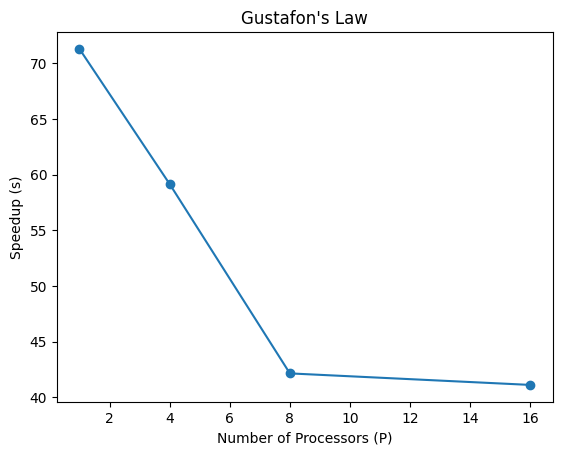

In [ ]:
import matplotlib.pyplot as plt

# Define the times and processors
times = [71.2781274318695, 59.14844512939453, 42.140639305114746, 41.10582995414734]
processors = [1, 4, 8, 16]

# Create a line plot
plt.plot(processors, times, marker = 'o')

# Add labels and title
plt.title("Gustafon's Law")
plt.ylabel("Speedup (s)")
plt.xlabel("Number of Processors (P)")

# Display plot
plt.show()

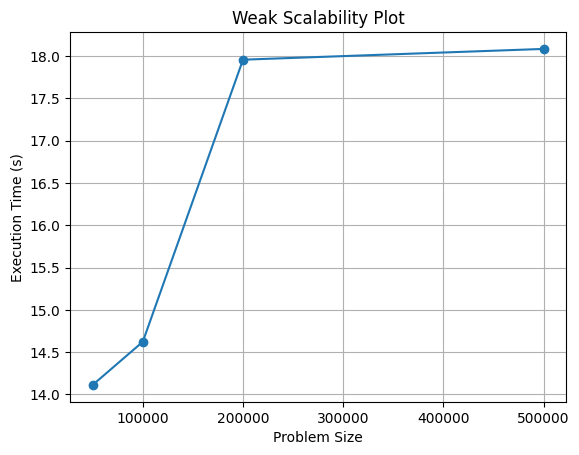

In [ ]:
problem_sizes = [50000, 100000, 200000, 500000]
execution_times = [14.112447023391724, 14.622412204742432, 17.955886840820312, 18.083254098892212]  # Execution times in seconds

# Plotting the scalability
plt.plot(problem_sizes, execution_times, marker='o')
plt.xlabel('Problem Size')
plt.ylabel('Execution Time (s)')
plt.title('Weak Scalability Plot')
plt.grid(True)
plt.show()